# Project 1

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
# Importing standard libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import resample

In [5]:
# Importing project-specific files
from FrankeFunction import FrankeFunction, SimpleFunction
from MLFunctions import DesignMatrix, OLS_matrix_inversion, OLS_SVD, bias_variance_tradeoff
from MLFunctions import ridge_regression, lasso_regression
from MLFunctions import GradientDescent, StochasticGradientDescent
from Statistics import MSE, R2

In [6]:
# Defining data set
step_size = 0.05
arr = np.arange(0, 1, step_size)

Mat = np.meshgrid(arr, arr)
data = FrankeFunction(*Mat, noise=0)

## Part a): Ordinary Least Square (OLS) on the Franke function
### Performing standard least square regression, and plotting the result.

In [7]:
X = DesignMatrix(arr, arr, 5)               # defining design matrix
beta_inv = OLS_matrix_inversion(X, data)    # computing polynomal coefficients usnig matrix inversion
beta_svd = OLS_SVD(X, data)                 # computing polynomal coefficients usnig singular value decomp
model = X @ beta_inv

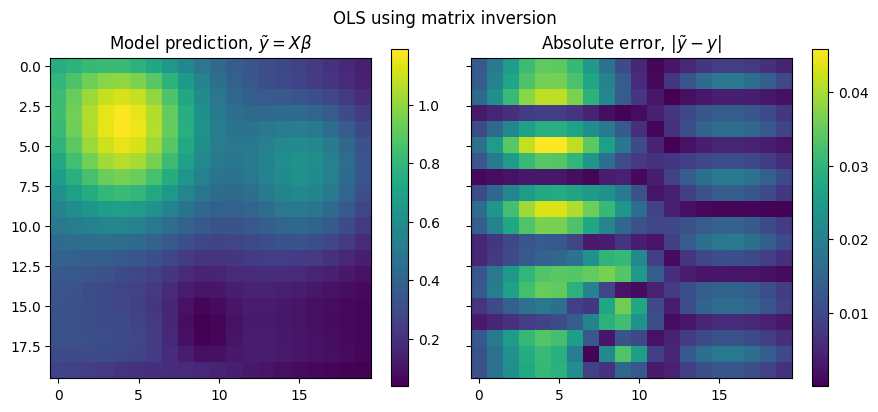

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(9,4), sharex=True, sharey=True)
fig.suptitle("OLS using matrix inversion")
im0 = ax[0].imshow(model)
im1 = ax[1].imshow(abs(data - model))

ax[0].set(title="Model prediction, " + r"$\tilde{y} = X \beta$")
ax[1].set(title=r"Absolute error, " + r"$|\tilde{y} - y|$")

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

fig.tight_layout()

**Left plot:** Using matrix inversion to predict model of the Franke function without noise.  
**Right plot:** Absolute difference between model prediction and actual data.

In [9]:
# Computing errors
mse = MSE(data, model)
r2 = R2(data, model)

print(f"Mean-square-error: {mse:0.6f}\nR^2 score function: {r2:0.6f}")

Mean-square-error: 0.000336
R^2 score function: 0.995886


The mean square error is very low, and the $R^2$ score function is close to 1, so our model is pretty good...

### Now, we split our data in sets of training data and testing data
Here, we want to discuss ways to scale and split data. Use between 0.6-0.8 of data as training data.

## Part b): Bias-variance trade-off and resamplng techniques
### First, makeing figure of prediction error vs model complexity, for test and training models

In [10]:
Nreps = 100
max_degree = 15
test_size = 0.2 #1/3

In [11]:
# empty arrays for storing result
MSE_train = np.zeros(max_degree)
MSE_test = np.zeros(max_degree)
#error = np.zeros_like(MSE_test)
#bias = np.zeros_like(MSE_test)
#var = np.zeros_like(MSE_test)


# looping through complexity
for i in range(max_degree):
    X = DesignMatrix(arr, arr, i)
    #X_, X_test, y_, y_test = train_test_split(X, data, test_size=test_size, random_state=r)
    #y_pred = np.zeros([Nreps, y_test.shape[0], y_test.shape[1]])
    #y_comp = np.zeros([Nreps, y_test.shape[0], y_test.shape[1]])
    
    # looping through repetitions
    for rep in range(Nreps):
        # performing OLS
        r = int(100 * np.random.rand())
        X_, X_test, y_, y_test = train_test_split(X, data, test_size=test_size, random_state=r)
        beta = OLS_matrix_inversion(X_, y_)

        # computing average
        MSE_train[i] += MSE(y_, X_ @ beta) / Nreps
        MSE_test[i] += MSE(y_test, X_test @ beta) / Nreps

        #y_pred[rep] = X_test @ beta
        #y_comp[rep] = y_test

        #print(MSE_test[i])

    #Exp_y = np.mean(y_pred, axis=0)
    #error[i] = np.mean( (y_comp - y_pred)**2 )
    #bias[i] = np.mean( (y_comp -  Exp_y)**2 )
    #var[i]  = np.mean( (y_pred -  Exp_y)**2 )

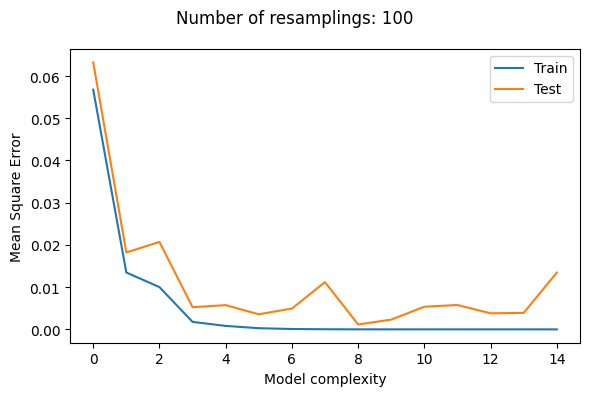

In [12]:
complexity = np.arange(max_degree)

fig, ax = plt.subplots(1,1, figsize=(6,4))
fig.suptitle(f"Number of resamplings: {Nreps}")

ax.set(xlabel="Model complexity", ylabel="Mean Square Error")
ax.plot(complexity, MSE_train, label="Train")
ax.plot(complexity, MSE_test, label="Test")
#ax.plot(complexity, error, '-')
#ax.plot(complexity, bias+var, '--')
#ax.plot(complexity, var, '--')
ax.legend()

fig.tight_layout()

Whereas the error decreases with model complexity for the training data, the error on the test data increases at some point because of overtraining.
N.B.: here we have not yet used bootstrapping.

### Bias-variance analysis
The mean square error can be written as:
$E\left[(\mathbf{y} - \mathbf{\tilde{y}})^2\right] = \frac{1}{n}\sum_i (y_i - E[\tilde{\mathbf{y}}])^2 + \frac{1}{n}\sum_i (\tilde{y_i} - E[\tilde{\mathbf{y}}])^2 + \sigma^2$.

The first term, $\frac{1}{n}\sum_i (y_i - E[\tilde{\mathbf{y}}])^2$, is the square of the bias, because it is the difference between data points and prediction average, i.e. a measure of how far the center of our model is from the actual data it is trying to capture.

The second term, $\frac{1}{n}\sum_i (\tilde{y_i} - E[\tilde{\mathbf{y}}])^2 = E[\tilde{\mathbf{y}}^2] - E[\tilde{\mathbf{y}}]^2$, is the variance, which can be seen mathematically, or by realising that it is the mean squared error of our model.

### Performing the bias-variance analysis

In [13]:
n_bootstraps = 100
max_degree = 12
test_size = 0.2

error, bias2, variance = bias_variance_tradeoff(data, arr, resampling_method='bootstrap', method_params=n_bootstraps, max_degree=max_degree, test_size=test_size)

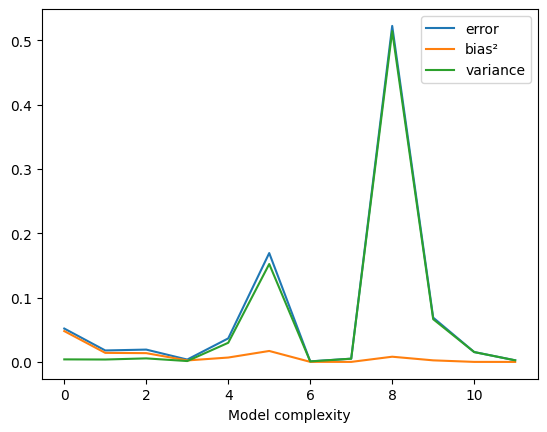

In [14]:
fig, ax = plt.subplots(1,1)
ax.plot(error, label="error")
ax.plot(bias2, label="bias²")
ax.plot(variance, label="variance")
ax.set(xlabel="Model complexity")

ax.legend();

Something is off here. Problem seems to come from resampling, since when modifying code generating MSE-figure it behaves similarily. Is bootstrapping implemented wrong?

## Part c): Cross-validation and resampling techniques
### Scale data

### Implement the k-fold cross-validation algorithm

In [15]:
max_degree = 20
test_size = 0.1

error, bias2, variance = bias_variance_tradeoff(data, arr, resampling_method='cross-validation', max_degree=max_degree, test_size=test_size)


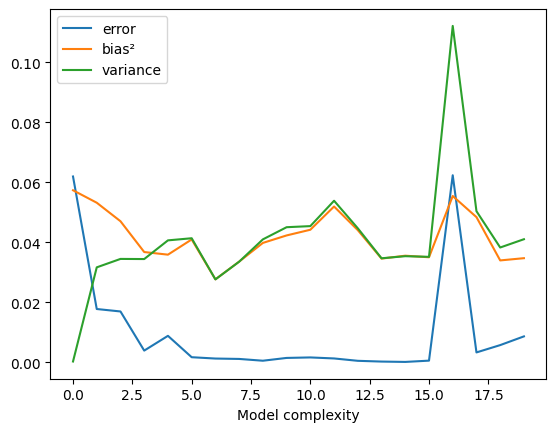

In [16]:
fig, ax = plt.subplots(1,1)
ax.plot(error, label="error")
ax.plot(bias2, label="bias²")
ax.plot(variance, label="variance")
ax.set(xlabel="Model complexity")

ax.legend();

## Part d): Ridge Regression on the Franke function with resampling

In [17]:
lmbd = 0.1
beta_ridge = ridge_regression(X, data, lmbd)
model_ridge = X @ beta_ridge


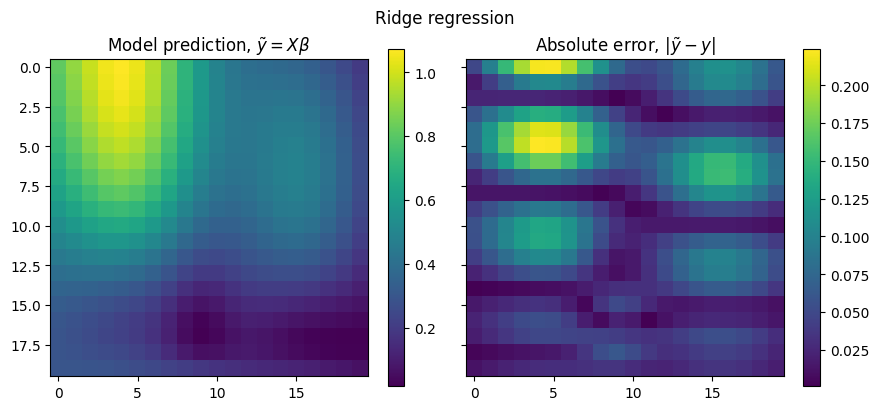

In [18]:

fig, ax = plt.subplots(1, 2, figsize=(9,4), sharex=True, sharey=True)
fig.suptitle("Ridge regression")
im0 = ax[0].imshow(model_ridge)
im1 = ax[1].imshow(abs(data - model_ridge))

ax[0].set(title="Model prediction, " + r"$\tilde{y} = X \beta$")
ax[1].set(title=r"Absolute error, " + r"$|\tilde{y} - y|$")

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

fig.tight_layout()

### Bootstrapping with Ridge regression

### Cross-validation with Ridge regression

### Bias-variance tradeoff

## Part e): Lasso regression

In [19]:
lmbd = 0.1
beta_lasso, model_lasso = lasso_regression(X, data, lmbd)
model2_lasso = X @ beta_lasso.T


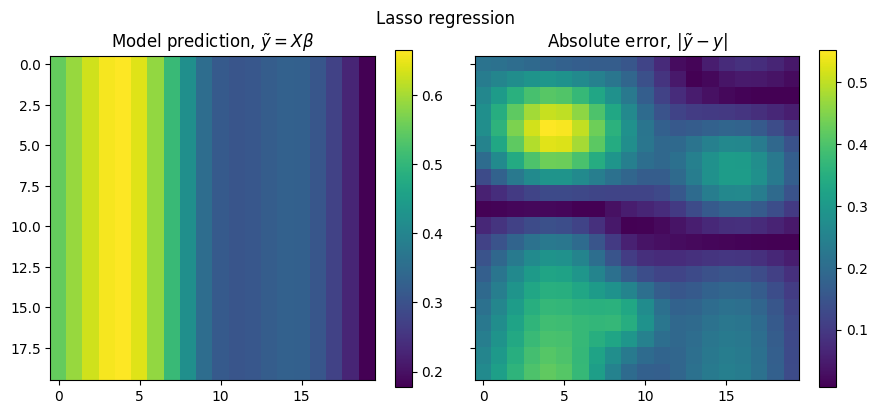

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(9,4), sharex=True, sharey=True)
fig.suptitle("Lasso regression")
im0 = ax[0].imshow(model_lasso)
im1 = ax[1].imshow(abs(data - model_lasso))

ax[0].set(title="Model prediction, " + r"$\tilde{y} = X \beta$")
ax[1].set(title=r"Absolute error, " + r"$|\tilde{y} - y|$")

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

fig.tight_layout()

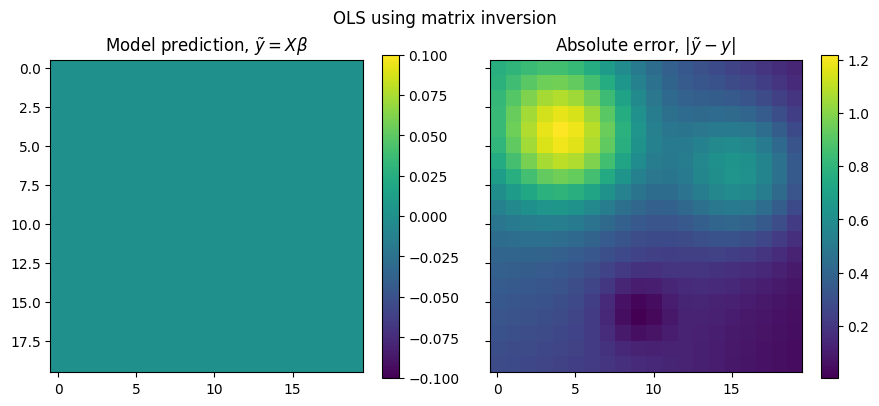

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(9,4), sharex=True, sharey=True)
fig.suptitle("OLS using matrix inversion")
im0 = ax[0].imshow(model2_lasso)
im1 = ax[1].imshow(abs(data - model2_lasso))

ax[0].set(title="Model prediction, " + r"$\tilde{y} = X \beta$")
ax[1].set(title=r"Absolute error, " + r"$|\tilde{y} - y|$")

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

fig.tight_layout()

### Bootstrapping with Lasso regression

### Cross-validation with Lasso regression

### Bias-variance tradeoff

## Part f): Write your own Stochastic Gradient Descent code
### 1. Plain gradient descent with fixed learning rate

In [22]:
# defining dataset 
X = np.c_[np.ones_like(arr), arr, arr**2]
ndata, ndims = np.shape(X)

params = [2, 3, 4]
data = SimpleFunction(arr, params)

# performing gradient descent
tolerance = 1e-4
learning_rate = np.linspace(0.1, 1, 20)
niter_plain = np.zeros_like(learning_rate)
converged_plain = np.zeros_like(learning_rate)
cost_plain = np.zeros_like(learning_rate)


In [23]:

i = 0
for lr in learning_rate:
    beta_temp, niter_plain[i], cost_plain[i] = GradientDescent(X, data, learning_rate=lr, momentum=0);
    if sum(beta_temp - params) < tolerance :
        converged_plain[i] = 1

    i += 1

/home/silja/Programs/miniconda3/envs/compsci/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/silja/Documents/Courses/compsci/CompSci-Projets/Project1/Statistics.py:19: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.sum(M**2))
/home/silja/Documents/Courses/compsci/CompSci-Projets/Project1/MLFunctions.py:257: RuntimeWarning: overflow encountered in matmul
  grad = (2.0 / ndata) * X.T @ (X @ beta - data)
/home/silja/Documents/Courses/compsci/CompSci-Projets/Project1/MLFunctions.py:257: RuntimeWarning: invalid value encountered in matmul
  grad = (2.0 / ndata) * X.T @ (X @ beta - data)
/home/silja/Documents/Courses/compsci/CompSci-Projets/Project1/MLFunctions.py:258: RuntimeWarning: invalid value encountered in multiply
  beta = beta - momentum * grad_prev - learning_rate * grad


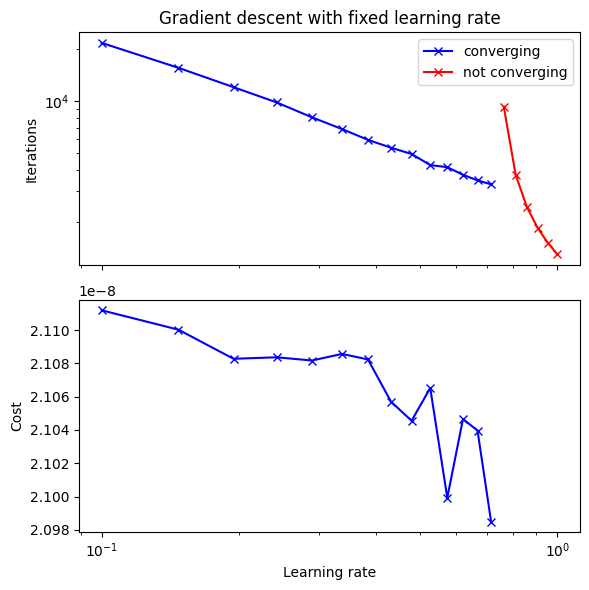

In [24]:
# tuning learning rate
fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True);

ax[0].plot(learning_rate[converged_plain==1], niter_plain[converged_plain==1], 'bx-', label="converging");
ax[0].plot(learning_rate[converged_plain==0], niter_plain[converged_plain==0], 'rx-', label="not converging");

ax[1].plot(learning_rate[converged_plain==1], cost_plain[converged_plain==1], 'bx-', label="converging");

ax[0].set(title="Gradient descent with fixed learning rate", ylabel="Iterations");
ax[1].set(xlabel="Learning rate", ylabel="Cost");

ax[0].set(xscale="log", yscale="log")
ax[0].legend();

fig.tight_layout()

### 2. Add momentum and compare convergence

/home/silja/Documents/Courses/compsci/CompSci-Projets/Project1/MLFunctions.py:258: RuntimeWarning: invalid value encountered in subtract
  beta = beta - momentum * grad_prev - learning_rate * grad


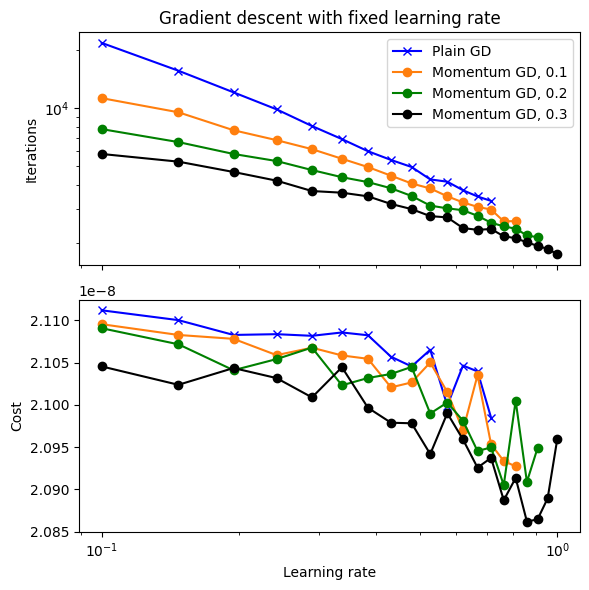

In [25]:
# tuning learning rate
fig, ax = plt.subplots(2, 1, figsize=(6,6), sharex=True);
ax[0].plot(learning_rate[converged_plain==1], niter_plain[converged_plain==1], 'bx-', label="Plain GD");
ax[1].plot(learning_rate[converged_plain==1], cost_plain[converged_plain==1], 'bx-', label="Plain GD");

# performing gradient descent
momentum = [0.1, 0.2, 0.3]
color = ['tab:orange', 'g', 'k']

j = 0
for mom in momentum:
    niter_momentum = np.zeros_like(learning_rate)
    converged_momentum = np.zeros_like(learning_rate)
    cost_momentum = np.zeros_like(learning_rate)

    i = 0
    for lr in learning_rate:
        beta_temp, niter_momentum[i], cost_momentum[i] = GradientDescent(X, data, learning_rate=lr, momentum=mom);
        if sum(beta_temp - params) < tolerance :
            converged_momentum[i] = 1

        i += 1

    ax[0].plot(learning_rate[converged_momentum==1], niter_momentum[converged_momentum==1], 'o-', c=color[j], label=f"Momentum GD, {mom}");
    ax[1].plot(learning_rate[converged_momentum==1], cost_momentum[converged_momentum==1], 'o-', c=color[j], label="Momentum GD");
    j += 1



ax[0].set(title="Gradient descent with fixed learning rate", ylabel="Iterations");
ax[1].set(xlabel="Learning rate", ylabel="Cost");

ax[0].set(xscale="log", yscale="log")
ax[0].legend();

fig.tight_layout()


### 3. Repeat for stochastic

In [26]:
batch_sizes = np.array([1, 2, 4, 5, 10, 20])
nepochs = np.arange(0, 200, 5)
cost_stoch = np.zeros([len(batch_sizes), len(nepochs)])

i = 0
for size in batch_sizes:
    j = 0
    for epochs in nepochs:
        beta_temp, cost_stoch[i, j] = StochasticGradientDescent(X, data, momentum=0, nepochs=epochs, batch_size=size)
        
        j += 1
    i += 1


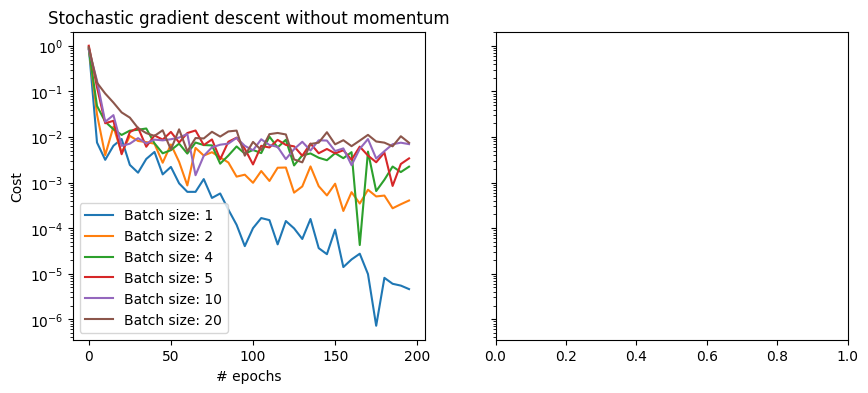

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for i in range(len(batch_sizes)):
    ax[0].plot(nepochs, cost_stoch[i], '-', label=f"Batch size: {batch_sizes[i]}")

ax[0].set(title="Stochastic gradient descent without momentum", xlabel="# epochs", ylabel="Cost")
ax[0].set(xscale="linear", yscale="log")
ax[0].legend()

In [28]:
cost_stoch = np.zeros([len(batch_sizes), len(nepochs)])

i = 0
for size in batch_sizes:
    j = 0
    for epochs in nepochs:
        beta_temp, cost_stoch[i, j] = StochasticGradientDescent(X, data, momentum=0.25, nepochs=epochs, batch_size=size)
        
        j += 1
    i += 1


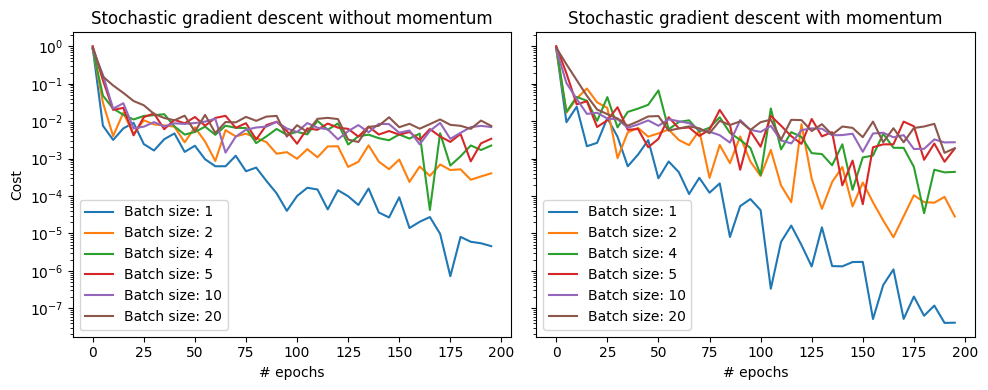

In [29]:
for i in range(len(batch_sizes)):
    ax[1].plot(nepochs, cost_stoch[i], '-', label=f"Batch size: {batch_sizes[i]}")

ax[1].set(title="Stochastic gradient descent with momentum", xlabel="# epochs")
ax[1].set(xscale="linear", yscale="log")
ax[1].legend()

fig.tight_layout()
fig

### 4. Implement ADAgrad to tune the learning rate

### 5. Add RMPSprop and Adam

## Part g): Write your Logistic Regression code

In [35]:
# importing libraries and functions
import pandas as pd
from Statistics import sigmoid
#from MLFunctions import LogisticCostFunction

In [ ]:

# importing dataset
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
cancer_pd = pd.DataFrame(cancer.data, columns=cancer.feature_names)

In [210]:
# defining dataset
dims = 500
X = cancer.data[0:dims, 0]
data = cancer.target[0:dims]
X = np.c_[np.ones(dims), X]
ndata, ndims = np.shape(X)

In [211]:
X

array([[ 1.   , 17.99 ],
       [ 1.   , 20.57 ],
       [ 1.   , 19.69 ],
       [ 1.   , 11.42 ],
       [ 1.   , 20.29 ],
       [ 1.   , 12.45 ],
       [ 1.   , 18.25 ],
       [ 1.   , 13.71 ],
       [ 1.   , 13.   ],
       [ 1.   , 12.46 ],
       [ 1.   , 16.02 ],
       [ 1.   , 15.78 ],
       [ 1.   , 19.17 ],
       [ 1.   , 15.85 ],
       [ 1.   , 13.73 ],
       [ 1.   , 14.54 ],
       [ 1.   , 14.68 ],
       [ 1.   , 16.13 ],
       [ 1.   , 19.81 ],
       [ 1.   , 13.54 ],
       [ 1.   , 13.08 ],
       [ 1.   ,  9.504],
       [ 1.   , 15.34 ],
       [ 1.   , 21.16 ],
       [ 1.   , 16.65 ],
       [ 1.   , 17.14 ],
       [ 1.   , 14.58 ],
       [ 1.   , 18.61 ],
       [ 1.   , 15.3  ],
       [ 1.   , 17.57 ],
       [ 1.   , 18.63 ],
       [ 1.   , 11.84 ],
       [ 1.   , 17.02 ],
       [ 1.   , 19.27 ],
       [ 1.   , 16.13 ],
       [ 1.   , 16.74 ],
       [ 1.   , 14.25 ],
       [ 1.   , 13.03 ],
       [ 1.   , 14.99 ],
       [ 1.   , 13.48 ],


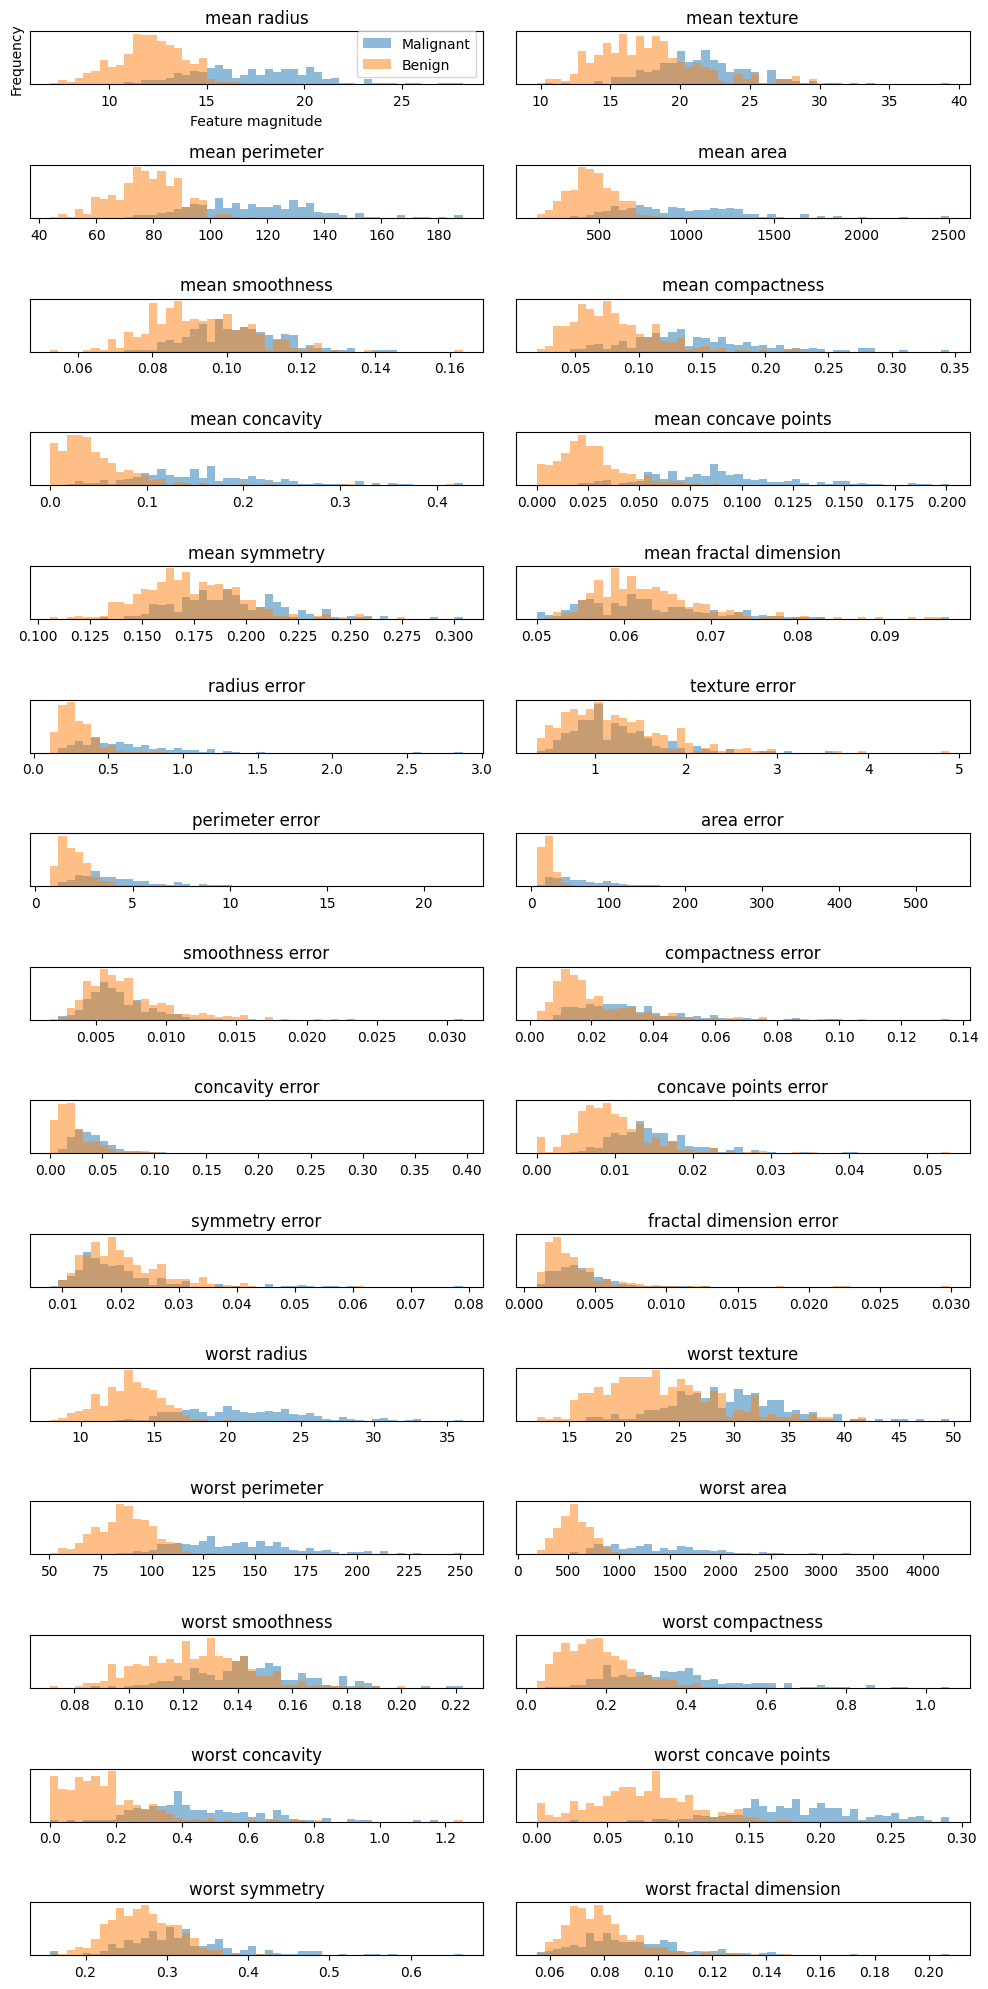

In [ ]:
# To be deleted
fig, axes = plt.subplots(15,2,figsize=(10,20))
malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]
ax = axes.ravel()

for i in range(30):
    _, bins = np.histogram(cancer.data[:,i], bins =50)
    ax[i].hist(malignant[:,i], bins = bins, alpha = 0.5)
    ax[i].hist(benign[:,i], bins = bins, alpha = 0.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["Malignant", "Benign"], loc ="best")
fig.tight_layout()
plt.show()


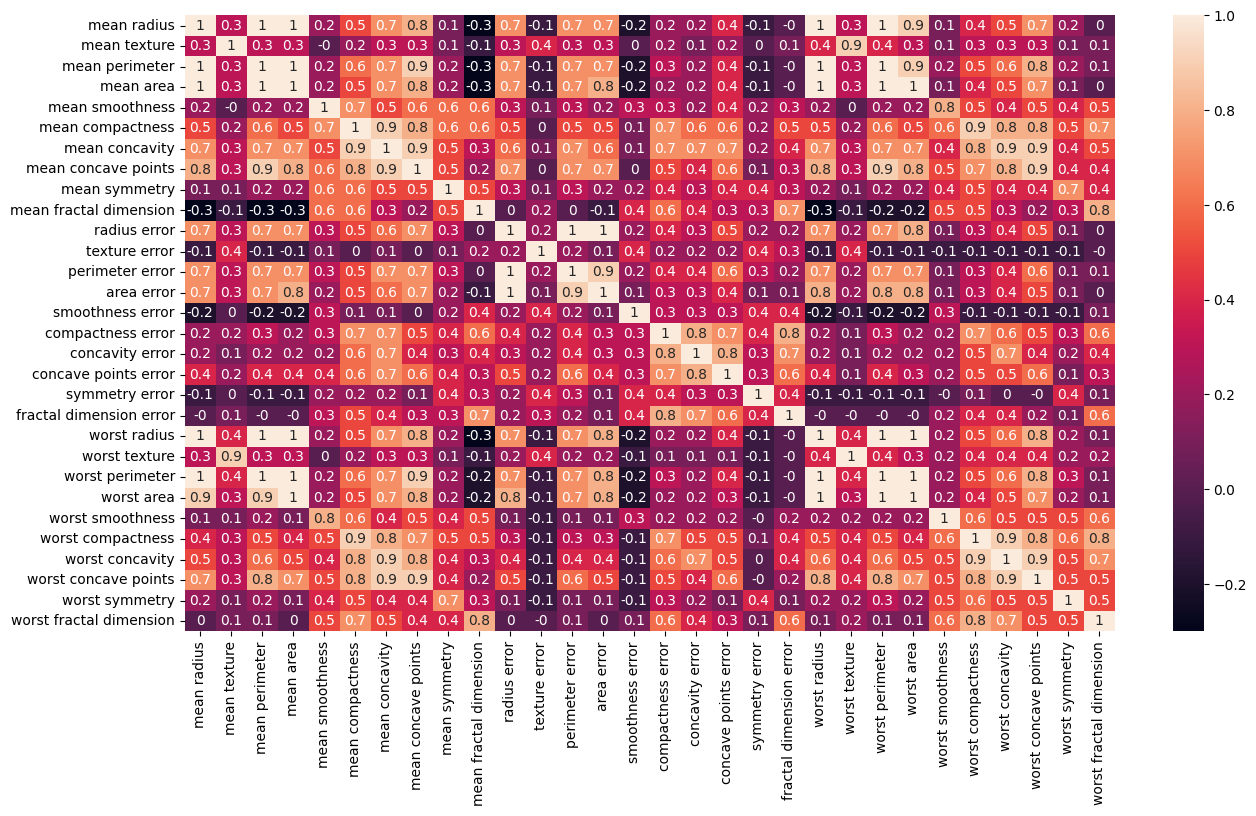

In [ ]:
# to be deleted

import seaborn as sns
correlation_matrix = cancer_pd.corr().round(1)
# use the heatmap function from seaborn to plot the correlation matrix
# annot = True to print the values inside the square
plt.figure(figsize=(15,8))
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

In [37]:
# split data in test and train
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, data, test_size=test_size)

# SGD with learning rate as hyper-parameter
beta_temp, cost_temp = StochasticGradientDescent(X_train, y_train, batch_size=4)


In [122]:
def LogisticProbability(X, beta):
    return sigmoid(X @ beta)

def LogisticCostFunction(X, data, beta):
    y_pred = beta @ X
    return -np.sum(data * y_pred - np.log(1 + np.exp(y_pred)), axis=0)

In [213]:
ndata, ndims = np.shape(X)

batch_size = 10
assert(ndata % batch_size == 0)
nbatches = int(ndata / batch_size)

# splitting up data in minibatches
X_batch = X.reshape(nbatches, batch_size, ndims)
data_batch = data.reshape(nbatches, batch_size)

# initial guesses for beta and the gradient
beta = np.random.rand(ndims) / dims
p = LogisticProbability(X, beta)
grad = (data - p) * p * (1 - p) @ X

(array([0.00121931, 0.00101143]),
 array([0.50485356, 0.50550586, 0.50528337, 0.5031924 , 0.50543507,
        0.50345284, 0.5049193 , 0.50377142, 0.5035919 , 0.50345536,
        0.50435548, 0.5042948 , 0.5051519 , 0.5043125 , 0.50377647,
        0.50398128, 0.50401667, 0.50438329, 0.50531371, 0.50372843,
        0.50361213, 0.50270795, 0.50418355, 0.50565503, 0.50451476,
        0.50463865, 0.50399139, 0.50501032, 0.50417343, 0.50474737,
        0.50501537, 0.5032986 , 0.50460831, 0.50517719, 0.50438329,
        0.50453752, 0.50390795, 0.50359948, 0.50409505, 0.50371326,
        0.50370315, 0.50307357, 0.50512662, 0.5036627 , 0.50363488,
        0.50502043, 0.50237722, 0.50363488, 0.5033517 , 0.50371579,
        0.50327837, 0.50375372, 0.50332388, 0.50491171, 0.50412287,
        0.50321769, 0.50516202, 0.50402426, 0.50360454, 0.50248392,
        0.50287635, 0.50247887, 0.50390795, 0.50262426, 0.50351099,
        0.50404196, 0.50269809, 0.50316459, 0.50258784, 0.50353627,
        0.5050

In [214]:
nepochs = 50
momentum = 0

In [215]:
# compute learning rate
H = (2 / ndata) *  X.T @ X
eigVal, _ = np.linalg.eig(H)
learning_rate = 1 / np.max(eigVal)

for epoch in range(nepochs):
    for batch in range(nbatches):
        # pick random minibatch
        idx = np.random.randint(nbatches)
        X_, data_ = X_batch[idx], data_batch[idx]
        p_ = LogisticProbability(X_, beta)

        # computing gradient over minibatch
        grad_prev = grad
        # grad = (2.0 / batch_size) * X_.T @ (X_ @ beta - data_)
        grad = (data_ - p_) * p_ * (1 - p_) @ X_
        
        # update beta
        beta = beta - momentum * grad_prev - learning_rate * grad

# compute cost
#cost = norm2(X @ beta - data) / ndata

In [221]:
# np.shape(learning_rate * grad)
#np.shape(momentum * grad_prev

array([0.99937532, 0.99919832, 0.99444378, 0.99917629, 0.98876474,
       0.99859878, 0.99935815, 0.99836033, 0.9994083 , 0.99851271,
       0.99813266, 0.99918517, 0.9910439 , 0.99612262, 0.99094704,
       0.99335767, 0.9943256 , 0.99790771, 0.99282162, 0.9990567 ,
       0.99225518, 0.99878295, 0.99937192, 0.99909675, 0.99806049,
       0.99930375, 0.99856029, 0.9988155 , 0.99965604, 0.99965228,
       0.99927681, 0.99934407, 0.9986941 , 0.99523107, 0.99821186,
       0.97850081, 0.9986941 , 0.99545492, 0.99673875, 0.99825019,
       0.9988155 , 0.99794143, 0.99520524, 0.99897678, 0.99957729,
       0.99677384, 0.99154944, 0.99850462, 0.99250952, 0.99801801,
       0.99962889, 0.99931499, 0.999472  , 0.99973201, 0.99870116,
       0.99980752, 0.99831531, 0.99803937, 0.99787344, 0.99510318,
       0.99803937, 0.99911613, 0.99716672, 0.99848012, 0.99970928,
       0.99961661, 0.99943954, 0.99916278, 0.98890257, 0.99508463,
       0.99771834, 0.99922818, 0.99874272, 0.99989575, 0.99860

In [ ]:
# output probability of belongnig to specific category
# correlation matrix?
# principal component?